**1. IMPORTER LES LIBRAIRIES**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import datetime

# Train_Test_Split
from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

# Ré-échantillonnage
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Modélisation
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced

# Modèles
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Enregistrement du modèle
from sklearn import model_selection
import joblib

import itertools
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

**2. IMPORTER LE FICHIER**

In [4]:
df = pd.read_csv("4. Stemming_TF-IDF(Avec_Reduction).csv").astype('float16')
df['y'] = df['y'].astype('uint8')
df = df.rename(columns={'1099' : 'ponctuation', '1100' : 'sentiment'})
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1092,1093,1094,1095,1096,1097,1098,ponctuation,sentiment,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.147949,-4.183594,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.147949,-3.720703,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.147949,5.550781,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.147949,4.390625,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.147949,0.625488,5


**3. PREPARATION DES DONNEES**

In [5]:
### Classification binaire
# Classe 0 : [1, 2, 3]
# Classe 1 : [4, 5]
df['y'] = df['y'].replace((1, 2, 3, 4, 5), (0, 0, 0, 1, 1))

### Séparation target/features
X = df.drop('y', axis=1).to_numpy()
y = df['y'].to_numpy()

### Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**4. MODELISATION DES 16 COMBINAISONS**

In [ ]:
######################################
### DEFINITION DES 16 COMBINAISONS ###
######################################
# Stocker les résultats des combinaisons dans un tableau récapitulatif
results_summary = []

# Définir les options pour les combinaisons
acp_options = [True, False]
sampling_options = ['undersampling', 'oversampling']
model_options = ['SVC', 'Random forest', 'Regression linéaire', 'K Neighbors']

# Générer toutes les combinaisons possibles
combinations = list(itertools.product(acp_options, sampling_options, model_options))

# Afficher les combinaisons dans un tableau
table_data = [(index + 1, *combo) for index, combo in enumerate(combinations)]
headers = ['Index', 'ACP', 'Sampling', 'Model']

print(tabulate(table_data, headers=headers, tablefmt='grid'))

+---------+-------+---------------+---------------------+
|   Index | ACP   | Sampling      | Model               |
+=========+=======+===============+=====================+
|       1 | True  | undersampling | SVC                 |
+---------+-------+---------------+---------------------+
|       2 | True  | undersampling | Random forest       |
+---------+-------+---------------+---------------------+
|       3 | True  | undersampling | Regression linéaire |
+---------+-------+---------------+---------------------+
|       4 | True  | undersampling | K Neighbors         |
+---------+-------+---------------+---------------------+
|       5 | True  | oversampling  | SVC                 |
+---------+-------+---------------+---------------------+
|       6 | True  | oversampling  | Random forest       |
+---------+-------+---------------+---------------------+
|       7 | True  | oversampling  | Regression linéaire |
+---------+-------+---------------+---------------------+
|       8 | Tr

In [ ]:
######################################
### EVALUATION DES 16 COMBINAISONS ###
######################################
# Définir la fonction apply_pca
def apply_pca(X):
    pca = PCA(n_components=2)  # Nous avions déjà calculé dans un autre modèle avec 2 composantes principales
    return pca.fit_transform(X)

# Fonction pour entraîner le modèle et afficher les résultats
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_name, sampling_type, use_pca=False):
    if use_pca:
        X_train = apply_pca(X_train)
        X_test = apply_pca(X_test)

    if model_name == 'SVC':
        model = SVC()
    elif model_name == 'Random forest':
        model = RandomForestClassifier()
    elif model_name == 'Regression linéaire':
        model = LogisticRegression()
    elif model_name == 'K Neighbors':
        model = KNeighborsClassifier()

    if sampling_type == 'undersampling':
        sampler = RandomUnderSampler()
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif sampling_type == 'oversampling':
        sampler = RandomOverSampler()
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    return conf_matrix, class_report

# Parcourir toutes les combinaisons
results_summary = []
for idx, combination in enumerate(combinations, start=1):
    acp, sampling, model = combination

    conf_matrix, class_report = train_and_evaluate_model(X_train, X_test, y_train, y_test, model, sampling, use_pca=acp)

    results_summary.append({
        "Combinaison": idx,
        "ACP": "Avec" if acp else "Sans",
        "Sampling": sampling,
        "Modèle": model,
        "Matrice de confusion": conf_matrix,
        "Rapport de classification": class_report
    })

# Afficher les combinaisons et résultats
table = []
for result in results_summary:
    table.append([
        result["Combinaison"],
        result["ACP"],
        result["Sampling"],
        result["Modèle"],
        result["Matrice de confusion"],
        result["Rapport de classification"]
    ])

headers = ["Combinaison", "ACP", "Sampling", "Modèle", "Matrice de confusion", "Rapport de classification"]

print("\n####################################")
print("### EVALUATION DES 16 COMBINAISONS ###")
print("####################################")
print("start = time.time()")
print("################################################################################################9898989898989898989898989898989898")

print(tabulate(table, headers=headers, tablefmt="fancy_grid"))



####################################
### EVALUATION DES 16 COMBINAISONS ###
####################################
start = time.time()
################################################################################################9898989898989898989898989898989898
╒═══════════════╤═══════╤═══════════════╤═════════════════════╤════════════════════════╤═══════════════════════════════════════════════════════╕
│   Combinaison │ ACP   │ Sampling      │ Modèle              │ Matrice de confusion   │ Rapport de classification                             │
╞═══════════════╪═══════╪═══════════════╪═════════════════════╪════════════════════════╪═══════════════════════════════════════════════════════╡
│             1 │ Avec  │ undersampling │ SVC                 │ [[1438  673]           │ precision    recall  f1-score   support               │
│               │       │               │                     │  [2835 5248]]          │                                                       │
│         

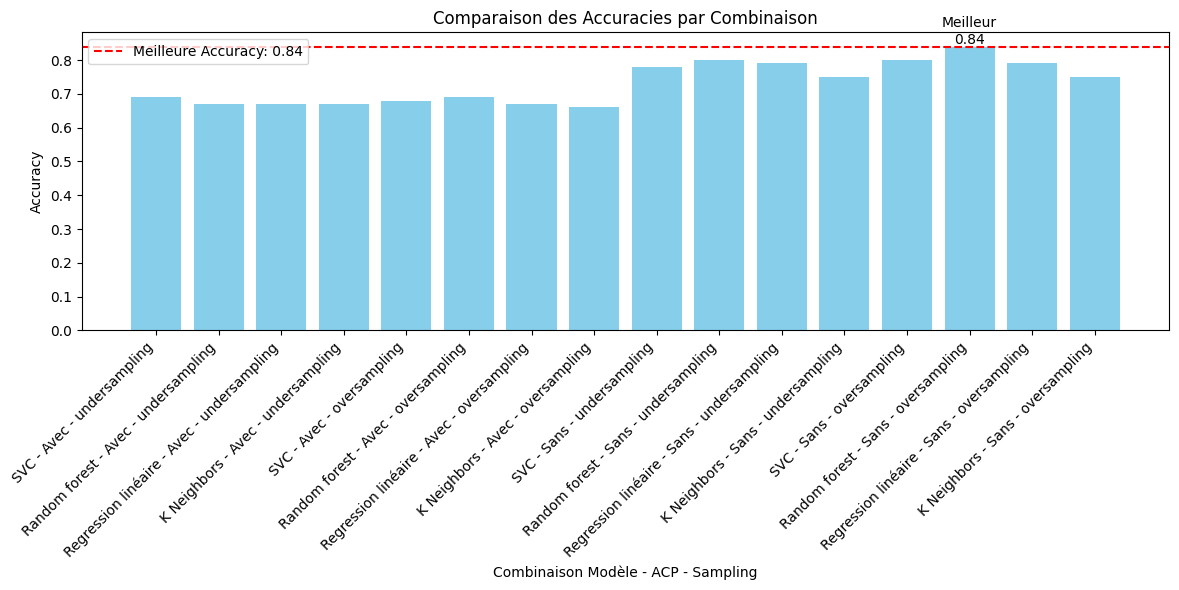

In [ ]:
###################################################
### GRAPHIQUE POUR COMPARER LES 16 COMPOSITIONS ###
###################################################
# Extraire l'accuracy des rapports de classification pour chaque combinaison
accuracies = [float(result["Rapport de classification"].split()[-2]) for result in results_summary]

# Trouver l'index de la meilleure composition (maximum de l'accuracy)
best_index = accuracies.index(max(accuracies))

# Extraire les noms des modèles et les labels ACP-Sampling pour chaque combinaison
labels = [f"{result['Modèle']} - {result['ACP']} - {result['Sampling']}" for result in results_summary]

# Créer un graphique bar pour comparer les accuracy
plt.figure(figsize=(12, 6))
plt.bar(labels, accuracies, color='skyblue')
plt.xlabel('Combinaison Modèle - ACP - Sampling')
plt.ylabel('Accuracy')
plt.title('Comparaison des Accuracies par Combinaison')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=max(accuracies), color='r', linestyle='--', label=f'Meilleure Accuracy: {max(accuracies):.2f}')
plt.legend()
plt.tight_layout()

# Annoter la barre avec la meilleure composition
plt.text(best_index, accuracies[best_index], f'Meilleur\n{max(accuracies):.2f}', ha='center', va='bottom')

# Afficher le graphique
plt.show()

**5. ENTRAÎNEMENT DE LA MEILLEURE COMBINAISON**

In [10]:
# Meilleure combinaison : Sans PCA, Oversampling, Random Forest

*1) Train_test_split*

In [11]:
X_train_stem, X_test_stem, y_train_stem, y_test_stem = model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)

# Vérification shape
print ("X_train_stem =", X_train_stem.shape)
print ("y_train_stem =", y_train_stem.shape)
print ("X_test_stem =", X_test_stem.shape)
print ("y_test_stem =", y_test_stem.shape)

X_train_stem = (55394, 1101)
y_train_stem = (55394,)
X_test_stem = (13849, 1101)
y_test_stem = (13849,)


*2) Ré-échantillonnage*

In [12]:
rOs = RandomOverSampler(random_state = 42)
X_ro_stem, y_ro_stem = rOs.fit_resample(X_train_stem, y_train_stem)
print('Classes échantillon oversampled stemming :', dict(pd.Series(y_ro_stem).value_counts()))

Classes échantillon oversampled stemming : {1: 44018, 0: 44018}


*3) Modélisation*

In [14]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_ro_stem, y_ro_stem)
y_pred_stem = clf_rf.predict(X_test_stem)
score = clf_rf.score(X_test_stem, y_test_stem)
print("Score du modèle :", score)

Score du modèle : 0.8527691530074374


*4) Performances*

In [15]:
print(classification_report_imbalanced(y_test_stem, y_pred_stem))

confusion_matrix = pd.crosstab(y_test_stem, y_pred_stem, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(confusion_matrix)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.66      0.57      0.92      0.61      0.73      0.51      2816
          1       0.89      0.92      0.57      0.91      0.73      0.55     11033

avg / total       0.85      0.85      0.65      0.85      0.73      0.54     13849



Classe prédite,0,1
Classe réelle,,
0,1616,1200
1,839,10194


**6. ENREGISTREMENT DU MODELE**

In [16]:
joblib.dump(clf_rf, '5.d) best_model2_combi.pkl')

['best_model2_combi.pkl']